# Focus Probe

This notebook trys to see what part this model looks at during prediction. 
For all three tasks.

In [431]:
import glob
import os
import random
from copyreg import pickle
import pickle as pkl
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from triton.ops import attention

from model_incremental import *
from model_dataset import TokenMap
from paths import *
from H_1_models import TwoConvNetwork
def grad_cam(model, input_tensor, target_layer, target_class):
    '''
    get one attention result(normalized) for one input and one model
    '''
    model.eval()  # Set the model to evaluation mode
    gradients = []
    activations = []
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    def forward_hook(module, input, output):
        activations.append(output)
    hook_b = target_layer.register_backward_hook(backward_hook)
    hook_f = target_layer.register_forward_hook(forward_hook)
    output = model(input_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()
    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]
    hook_b.remove()
    hook_f.remove()
    weights = np.mean(grad, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * act, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam 

    return cam

def get_one_batch(dataloader):
    dataloader_iter = iter(dataloader)  # Create an iterator
    batch = next(dataloader_iter)      # Get the first batch
    return batch

def grad_cam_visualization(input_tensor, cam, title="Grad-CAM Heatmap",input_alpha = 0.5,output_alpha = 0.3): 
    # Plot the heatmap on the test Mel spectrogram
    plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    plt.imshow(cam, cmap='jet', alpha=output_alpha, vmin=0, vmax=1, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    plt.colorbar(label='Attention')
    plt.title(title)
    plt.show()

def grad_cam_visualization_both(input_tensors, cams, title="Grad-CAM Heatmap",input_alpha = 0.5,output_alpha = 0.3): 
    # Plot the heatmap on the test Mel spectrogram
    it1, it2 = input_tensors
    cam1, cam2 = cams
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(it1.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    axs[0].imshow(cam1, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # axs[0].colorbar(label='Importance')
    # axs[0].title(title)
    axs[1].imshow(it2.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=input_alpha)
    axs[1].imshow(cam2, cmap='jet', alpha=output_alpha, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # axs[1].colorbar(label='Importance')
    # axs[1].title(title)
    # plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower', alpha=0.5)
    # plt.imshow(cam, cmap='jet', alpha=0.3, vmin=0, vmax=1, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    # fig.colorbar(label='Importance')
    plt.title(title)
    plt.show()

In [447]:
checking_domain = "stress" # pureTone, stress, tone

if checking_domain == "tone":
    # Setting for tone: 
    from model_dataset import ToneDatasetNew as ThisDataset
    configs = {
        "num_dataset": 50,"size_train": 1600,"size_valid": 320,"data_type": "mel",
        "total_epochs": 300, "lr": 1e-4,
        "data_type_mapper": {
            "f": "full", 
            "l": "low",
            "h": "high"}, 
        "lpp_configs": {
            "p1": 0.5, 
            "decay_rate": 0.3
        }, 
        "max_cache_size_train": 7, "max_cache_size_valid": 20, 
        "output_dim": 4, # tone: 4; tress: 3
    }
    # task
    mylist = ["1", "2", "3", "4"]# stress: ["0","1","2"] tone: ["1", "2", "3", "4"]
    train_name = "A3" # A3 -TONE, A4 -Pute tone, A5 stress
    ts_code = "1211014530"
    model_type = "twoconvCNN"
elif checking_domain == "pureTone":
    # Setting for tone: 
    from model_dataset import ToneDatasetNew as ThisDataset
    configs = {
        "num_dataset": 50,"size_train": 1600,"size_valid": 320,"data_type": "mel",
        "total_epochs": 300, "lr": 1e-4,
        "data_type_mapper": {
            "f": "full", 
            "l": "low",
            "h": "high"}, 
        "lpp_configs": {
            "p1": 0.5, 
            "decay_rate": 0.3
        },
        "max_cache_size_train": 7, "max_cache_size_valid": 20, 
        "output_dim": 4, # tone: 4; tress: 3
    }
    # task
    mylist = ["1", "2", "3", "4"]
    ts_code = "1207190600"
    train_name = "A4"
elif checking_domain == "stress":
    from model_dataset import SyllableDatasetNew as ThisDataset
    configs = {
    "num_dataset": 50,"size_train": 1600, "size_valid": 320,"data_type": "mel","total_epochs": 300,"lr": 1e-4,
    "data_type_mapper": {
        "f": "full", 
        "l": "low",
        "h": "high"
    }, 
    "lpp_configs": {
        "p1": 0.5, 
        "decay_rate": 0.3
    }, 
    "max_cache_size_train": 7, "max_cache_size_valid": 20, 
    "output_dim": 3, # tone: 4
    }
    mylist = ["0", "1", "2"]
    train_name = "A5" 
    ts_code = "0107020830"

In [448]:
total_epoch = 300
model_type = "twoconvCNN"
selection = "full"
pretype = "l"
posttype = "f"
valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)
full_valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)
mymap = TokenMap(mylist)
def get_one_dataset(dataset_id,pre_epoch,epoch,running_trial):
    ts = f"{ts_code}-{running_trial}"
    model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
    guides_dir = os.path.join(model_save_dir, "guides")
    model_save_dir_specific = os.path.join(model_save_dir, f"{model_type}-{pre_epoch}-{total_epoch-pre_epoch}", selection, f"{pretype}{posttype}")
    pool_messanger = PoolMessanger(configs["num_dataset"], configs["data_type_mapper"][pretype], configs["data_type_mapper"][posttype], guides_dir)
    # NOTE: Subset Cache, this is to manage the reading of datasets. Should be transparent to user. 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TwoConvNetwork(out_features=configs["output_dim"])
    model.to(device)
    model_path = os.path.join(model_save_dir_specific, f"{epoch}.pt")
    print(dataset_id, model_path)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                        eval_type="valid")
    valid_loader = valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)
    
    
    dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                        eval_type="full_valid")
    full_valid_loader = full_valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)
    valid_mel, valid_tag = valid_loader.dataset.dataset, valid_loader.dataset.gt_set
    full_valid_mel, full_valid_tag = full_valid_loader.dataset.dataset, full_valid_loader.dataset.gt_set

    def get_one_attention(random_idx:int):
        its, tsgs, cams = [], [], []
        one_valid_mel, one_valid_tag = valid_loader.dataset.__getitem__(random_idx)
        one_full_valid_mel, one_full_valid_tag = full_valid_loader.dataset.__getitem__(random_idx)
        label = one_valid_tag
        one_valid_mel = one_valid_mel.unsqueeze(0)
        one_full_valid_mel = one_full_valid_mel.unsqueeze(0)
        # transfer device
        one_valid_mel = one_valid_mel.to(device)
        one_full_valid_mel = one_full_valid_mel.to(device)
        layer_idx = 0
        # Grad-CAM valid
        input_tensor = one_valid_mel.to(torch.float32)
        target_layers = [model.conv[layer_idx]]
        targets = [ClassifierOutputTarget(one_valid_tag)]
        
        # Construct the CAM object once, and then re-use it on many images.
        with GradCAM(model=model, target_layers=target_layers) as cam:
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]
            # visualization = show_cam_on_image(one_valid_mel[0, 0, :, :], grayscale_cam, use_rgb=False)
            # grad_cam_visualization(one_valid_mel, grayscale_cam, title=f"Grad-CAM Valid {one_valid_tag}")
            its.append(input_tensor.cpu().half())
            tsgs.append(cam.outputs.argmax().item())
            cams.append(grayscale_cam.astype(np.float16))
            # You can also get the model outputs without having to redo inference
            # model_outputs = cam.outputs
        
        # Grad-CAM full
        input_tensor = one_full_valid_mel.to(torch.float32)
        target_layers = [model.conv[layer_idx]]
        targets = [ClassifierOutputTarget(one_full_valid_tag)]
        
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            its.append(input_tensor.cpu().half())
            tsgs.append(cam.outputs.argmax().item())
            cams.append(grayscale_cam.astype(np.float16))
        return its, tsgs, cams,label
    indexes = [i for i in range(len(valid_mel))]
    input_valid_tensors = []
    cam_valid_tensors = []
    input_full_tensors = []
    cam_full_tensors = []
    valid_predicts = []
    full_predicts = []
    labels = []
    for idx in indexes:
        its, tsgs, cams,label = get_one_attention(idx)
        valid_predicts.append(tsgs[0])
        full_predicts.append(tsgs[1])
        labels.append(label)
        input_valid_tensors.append(its[0])
        input_full_tensors.append(its[1])
        cam_valid_tensors.append(cams[0])
        cam_full_tensors.append(cams[1])
    result = {
        "dataset_id":dataset_id,
         "indexes":indexes,
         "labels":labels,
        "domain":checking_domain,
        "model":model_path,
        "pre_epoch":pre_epoch,
        "total_epoch":epoch,
        "run":running_trial,
        "cam_valid_tensors":cam_valid_tensors,
        "cam_full_tensors":cam_full_tensors,
        "valid_predicts":valid_predicts,
        "full_predicts":full_predicts
    }
    return result,input_valid_tensors,input_full_tensors,labels
# ave_valid_input = torch.mean(torch.stack(input_valid_tensors), dim=0)
# ave_full_input = torch.mean(torch.stack(input_full_tensors), dim=0)
# ave_valid_cam = np.mean(cam_valid_tensors, axis=0)
# ave_full_cam = np.mean(cam_full_tensors, axis=0)
# grad_cam_visualization_both([ave_valid_input,ave_full_input], [ave_valid_cam,ave_full_cam], title=f"Grad-CAM Heatmap",input_alpha=0,output_alpha=1)

In [449]:
pre = [10,20,30,40,50,60,70,80,90,100]
total = [i for i in range(1,21)]
condition = []
for i in pre:
    for j in total:
        epoch = j*10
        if epoch >= i:
            condition.append((i,epoch))
print(condition)

[(10, 10), (10, 20), (10, 30), (10, 40), (10, 50), (10, 60), (10, 70), (10, 80), (10, 90), (10, 100), (10, 110), (10, 120), (10, 130), (10, 140), (10, 150), (10, 160), (10, 170), (10, 180), (10, 190), (10, 200), (20, 20), (20, 30), (20, 40), (20, 50), (20, 60), (20, 70), (20, 80), (20, 90), (20, 100), (20, 110), (20, 120), (20, 130), (20, 140), (20, 150), (20, 160), (20, 170), (20, 180), (20, 190), (20, 200), (30, 30), (30, 40), (30, 50), (30, 60), (30, 70), (30, 80), (30, 90), (30, 100), (30, 110), (30, 120), (30, 130), (30, 140), (30, 150), (30, 160), (30, 170), (30, 180), (30, 190), (30, 200), (40, 40), (40, 50), (40, 60), (40, 70), (40, 80), (40, 90), (40, 100), (40, 110), (40, 120), (40, 130), (40, 140), (40, 150), (40, 160), (40, 170), (40, 180), (40, 190), (40, 200), (50, 50), (50, 60), (50, 70), (50, 80), (50, 90), (50, 100), (50, 110), (50, 120), (50, 130), (50, 140), (50, 150), (50, 160), (50, 170), (50, 180), (50, 190), (50, 200), (60, 60), (60, 70), (60, 80), (60, 90), (60,

In [ ]:
dataset_ids = [25,49] # 0,25,49
for id in dataset_ids:
    folderid = os.path.join(f'/mnt/storage/compling/proslearn/attention_check/{checking_domain}', f"dataset{id}")
    os.makedirs(folderid, exist_ok=True)
    for pre_epoch,epoch in condition:
        savename = f'{checking_domain}_dataset{id}_low{pre_epoch}e_total{epoch}e'
        runs = []
        for running_trial in [1,2,3,4,5]:
            attention_result,input_valid_tensors,input_full_tensors,labels = get_one_dataset(id,pre_epoch,epoch,running_trial)
            runs.append(attention_result)
        savepath = os.path.join(folderid, savename)
        pkl.dump(runs, open(savepath, "wb"))
    inputs = {
        "dataset_id":id,
        "domain":checking_domain,
        "input_valid_tensors":input_valid_tensors,
        "input_full_tensors":input_full_tensors,
        "labels":labels
    }
    saveinputpath = os.path.join(folderid, f"input")
    pkl.dump(inputs,open(saveinputpath, "wb"))

25 ../model_save/A5-0107020830-1/twoconvCNN-10-290/full/lf/10.pt
25 ../model_save/A5-0107020830-2/twoconvCNN-10-290/full/lf/10.pt


/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low100e_total140e


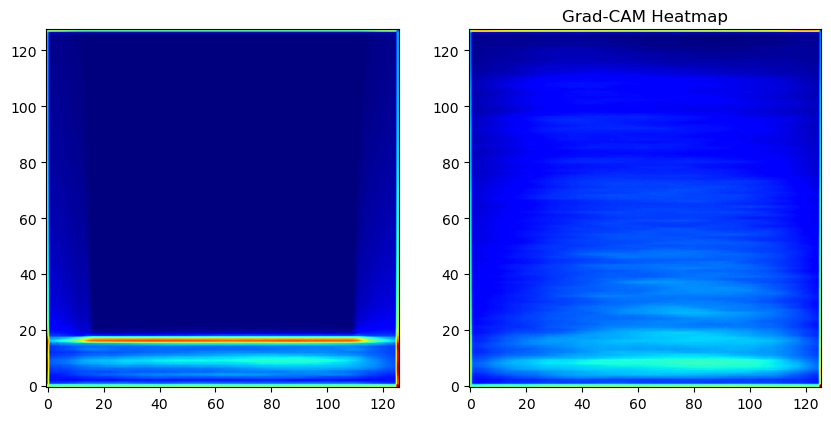

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total90e


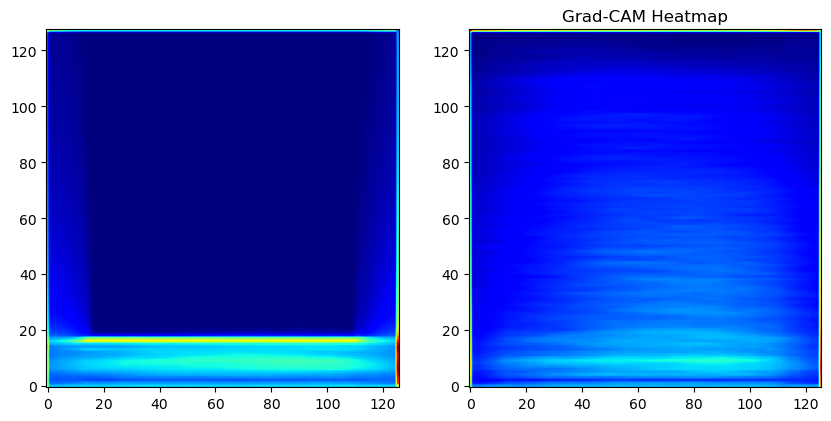

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low60e_total80e


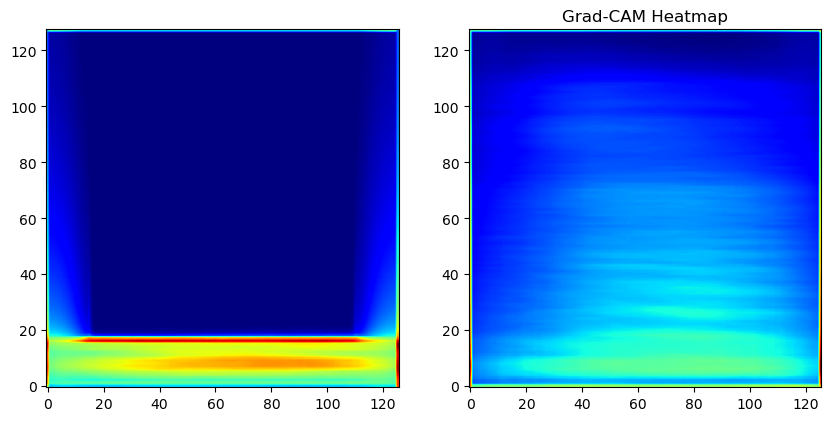

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low80e_total200e


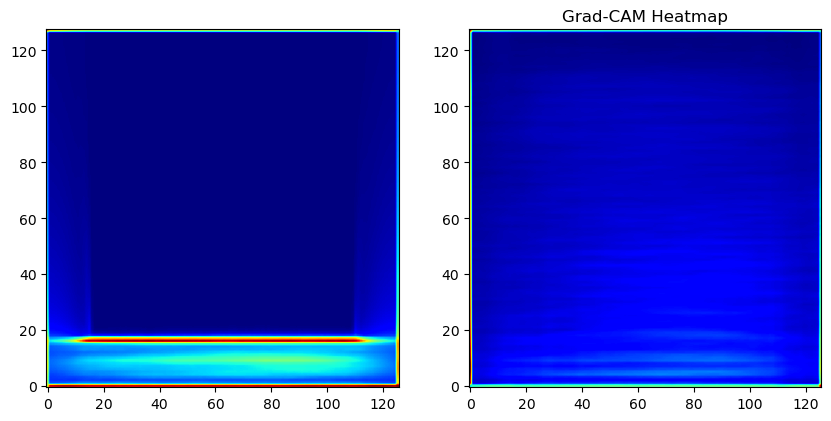

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low90e_total150e


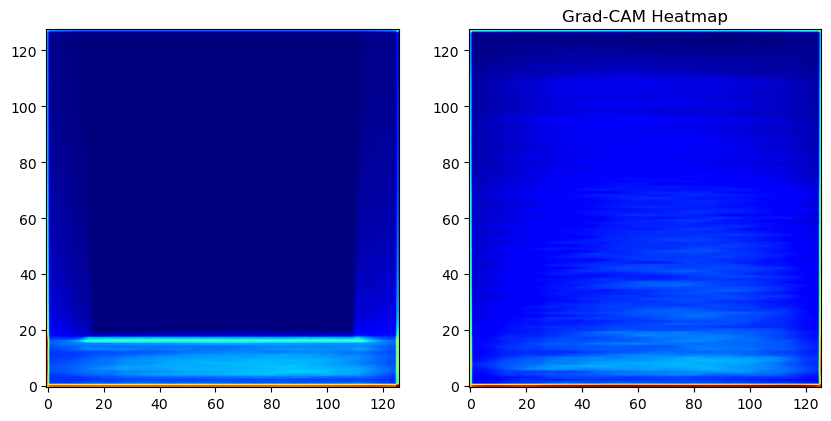

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total180e


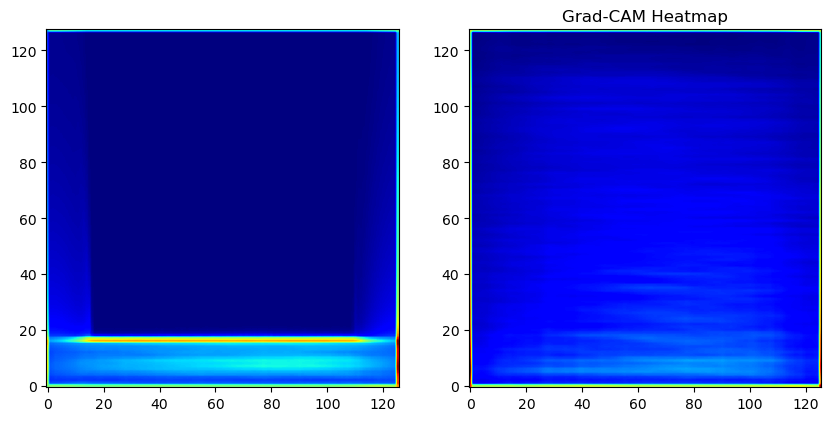

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low50e_total150e


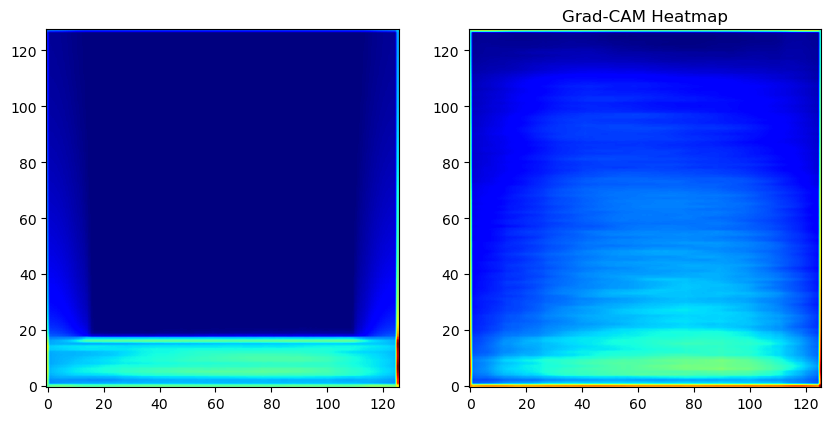

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total140e


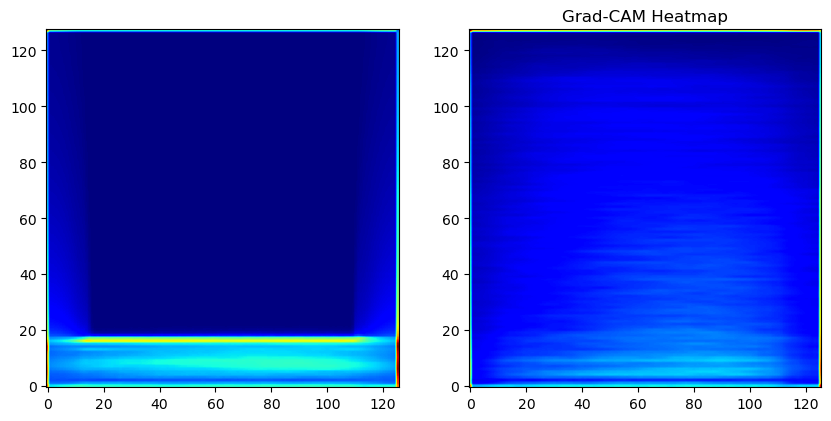

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total200e


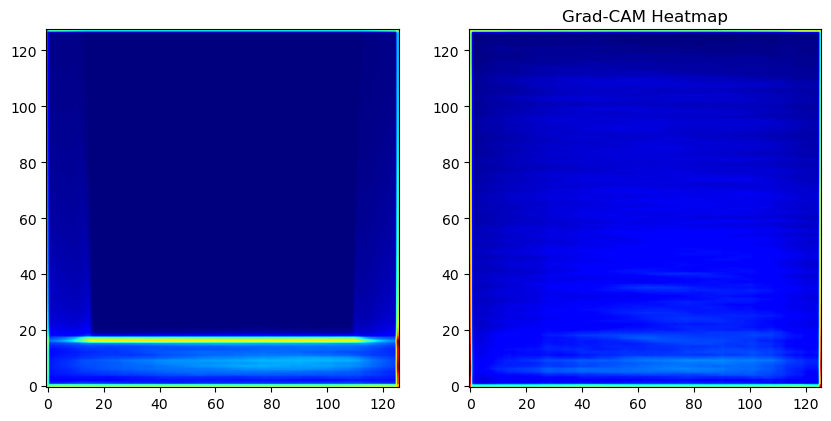

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low100e_total120e


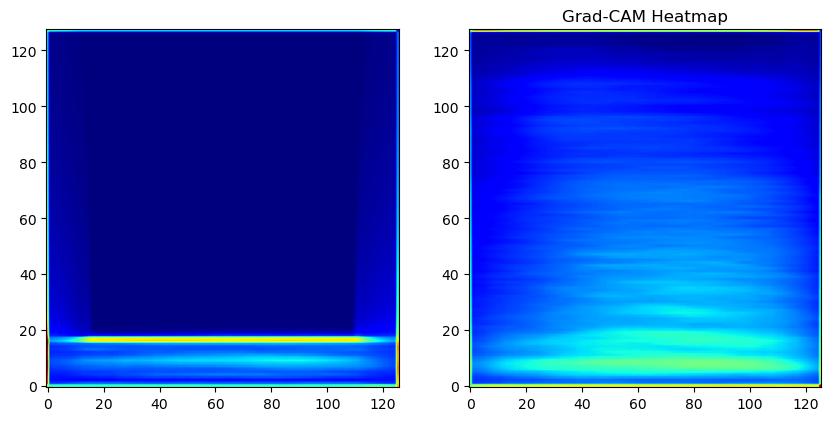

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low60e_total130e


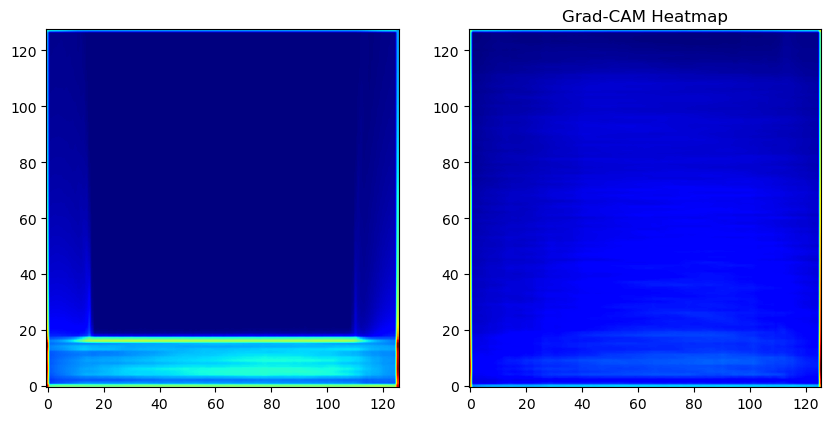

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total170e


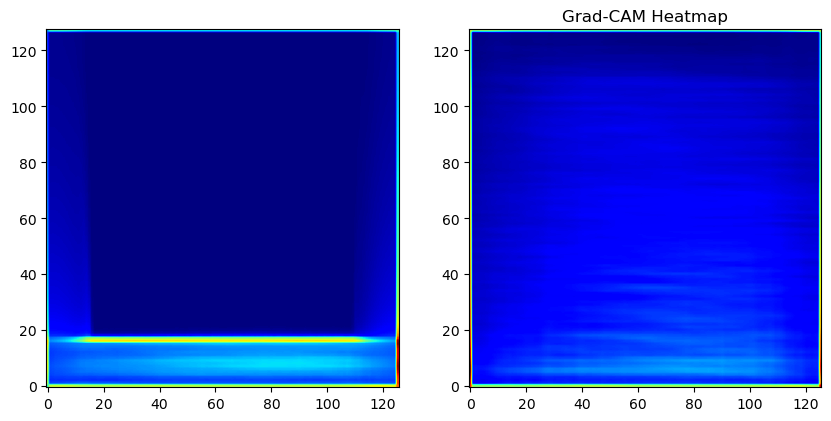

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total130e


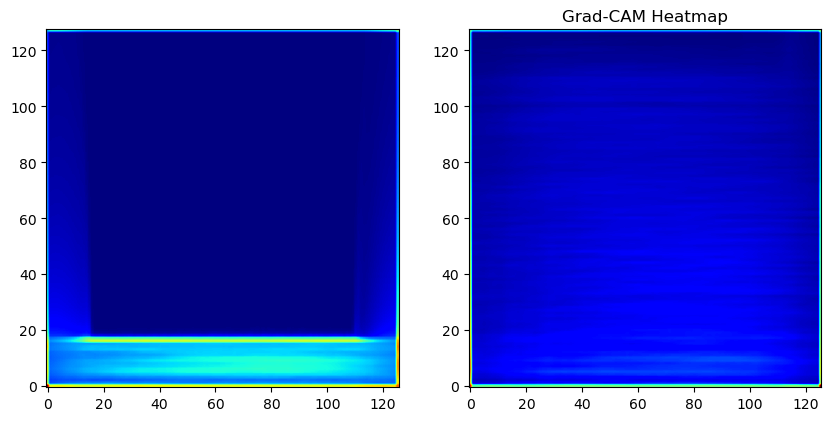

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total200e


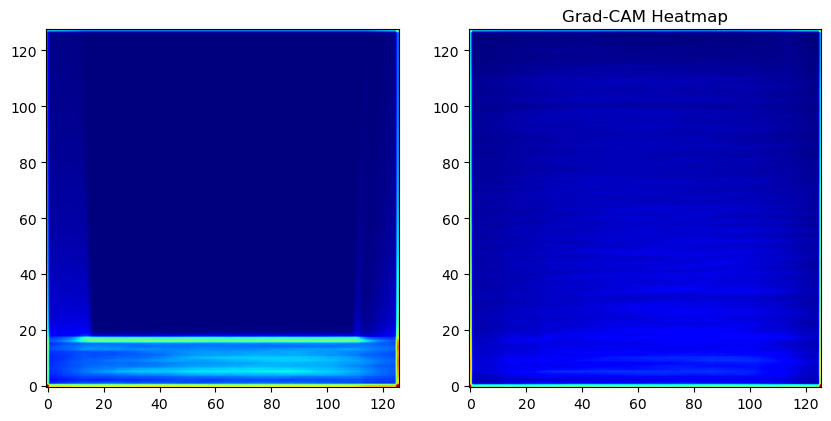

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low10e_total80e


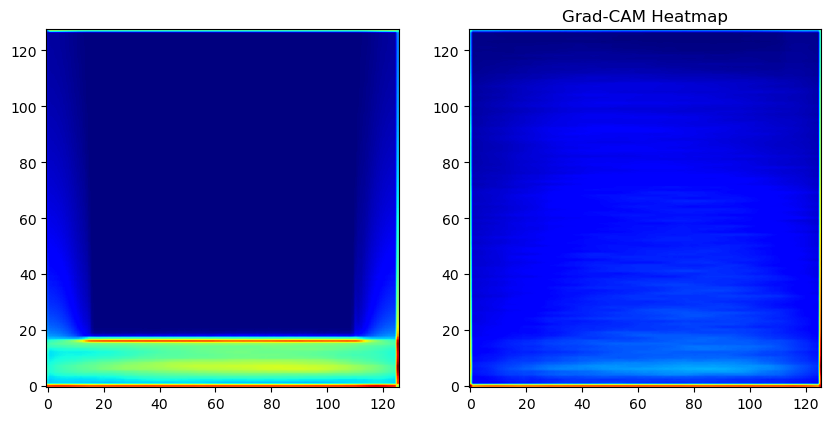

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low10e_total200e


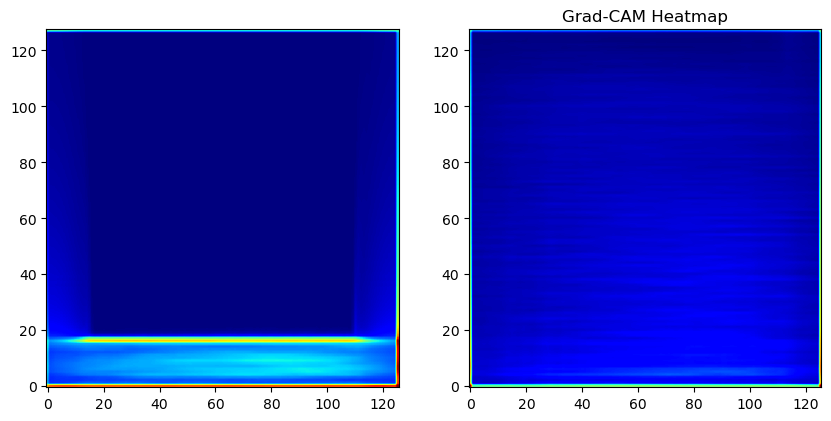

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low100e_total180e


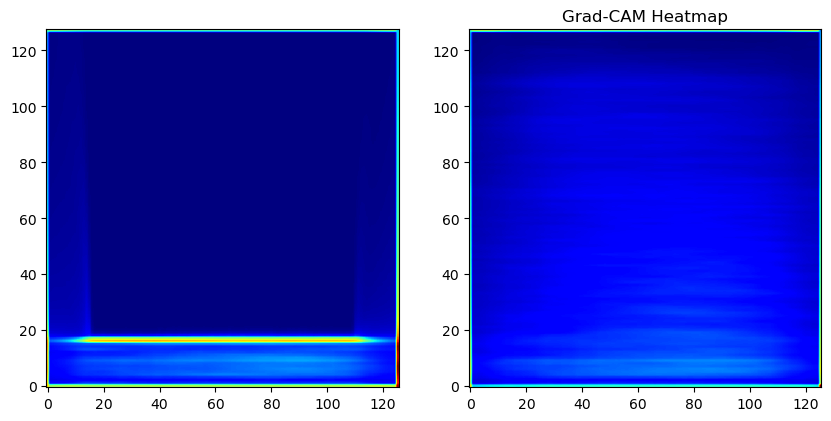

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low60e_total70e


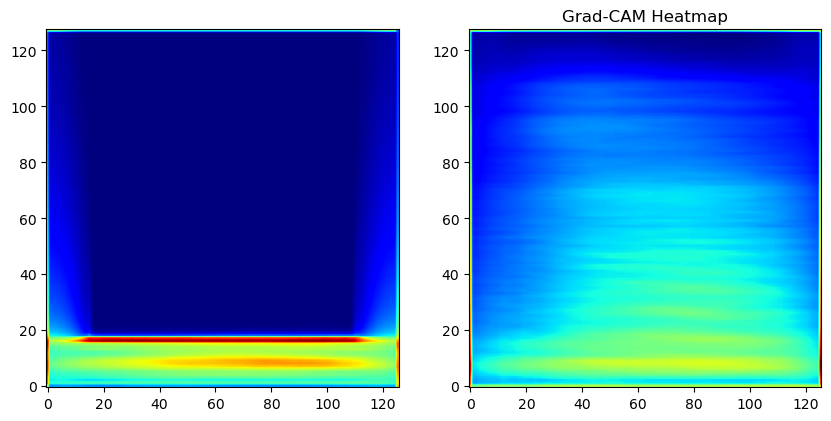

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total60e


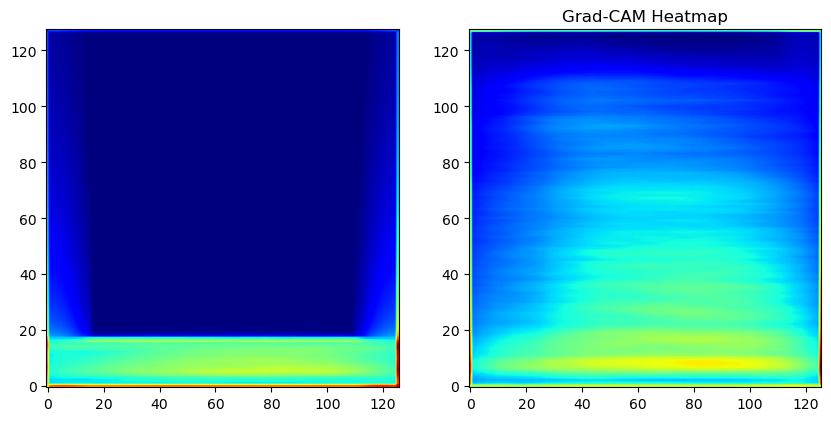

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low100e_total110e


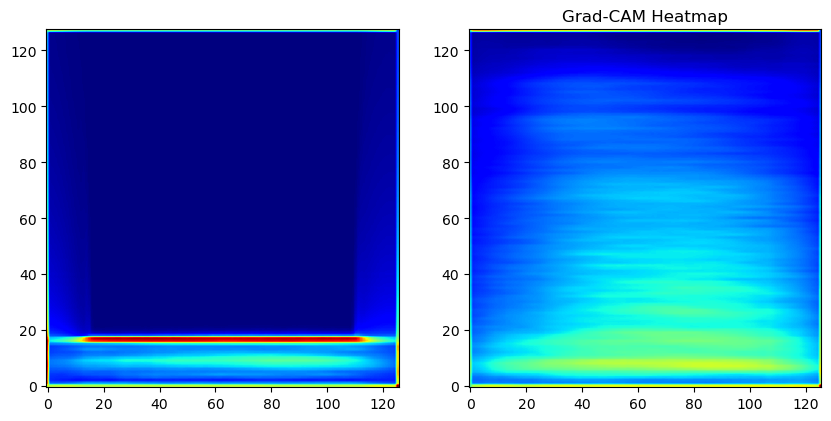

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low70e_total70e


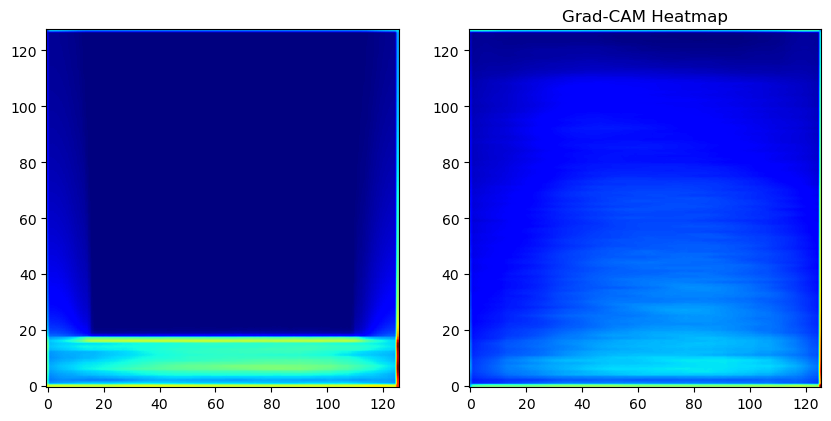

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low50e_total100e


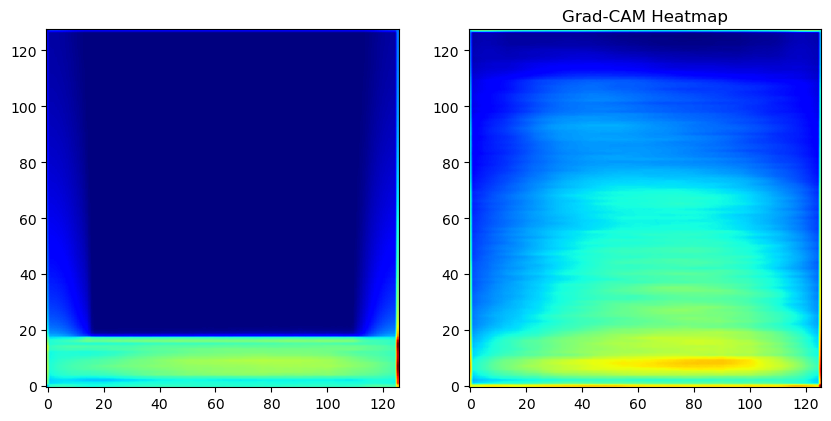

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total100e


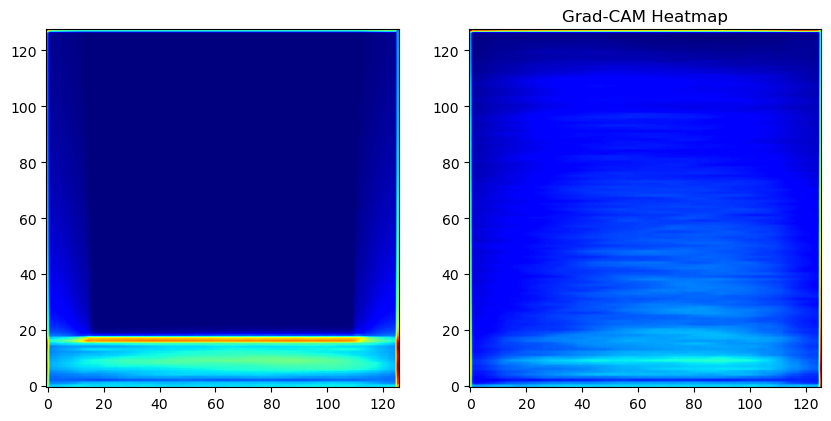

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total120e


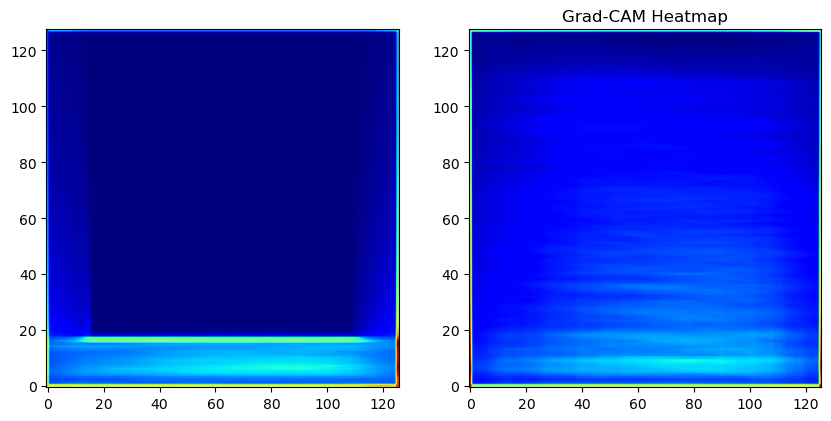

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low100e_total200e


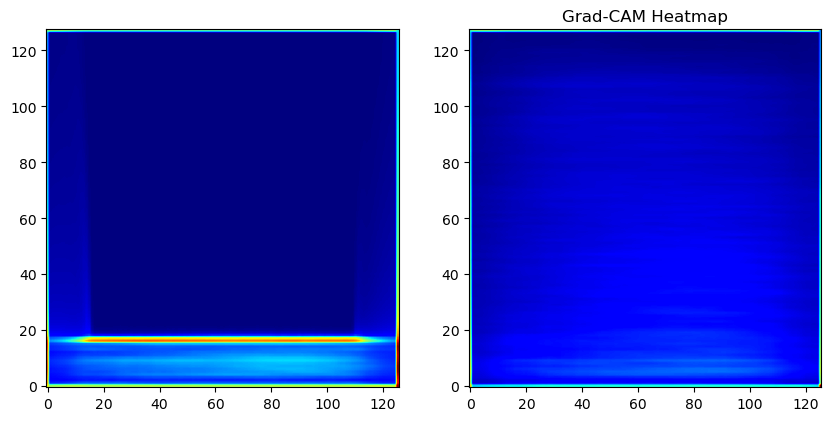

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low80e_total130e


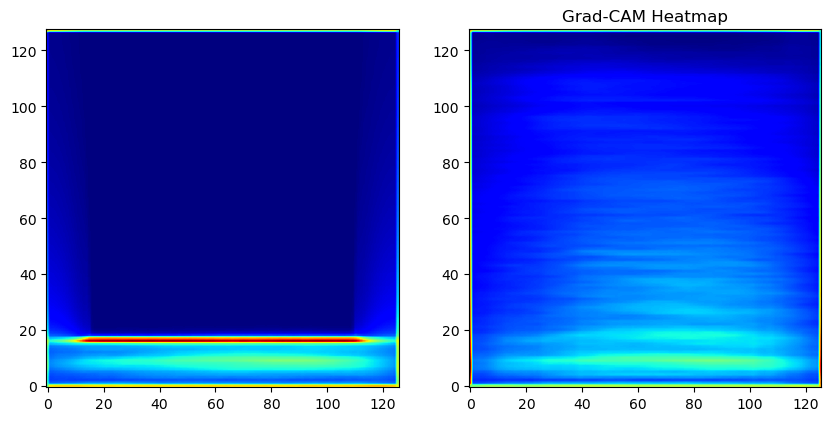

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low50e_total50e


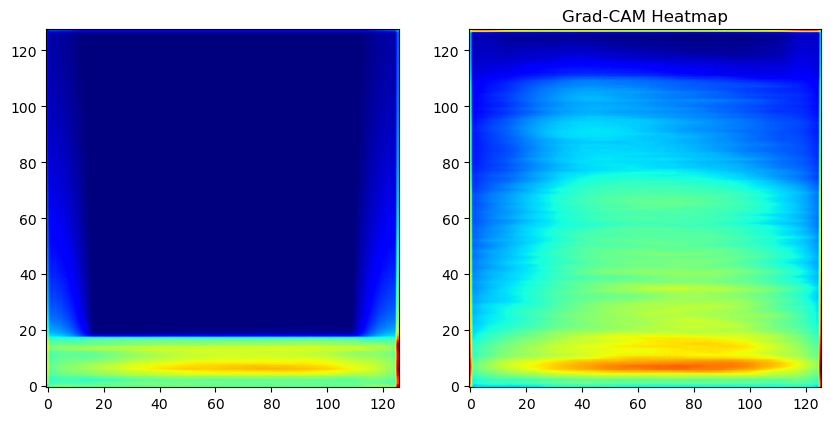

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low90e_total130e


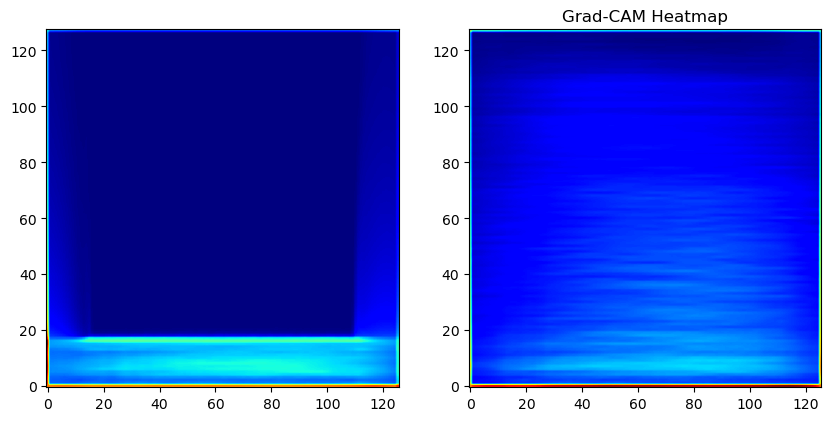

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low60e_total170e


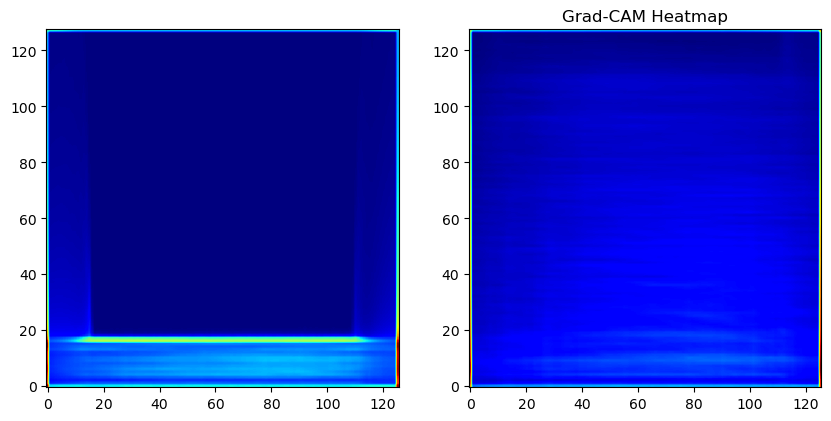

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total70e


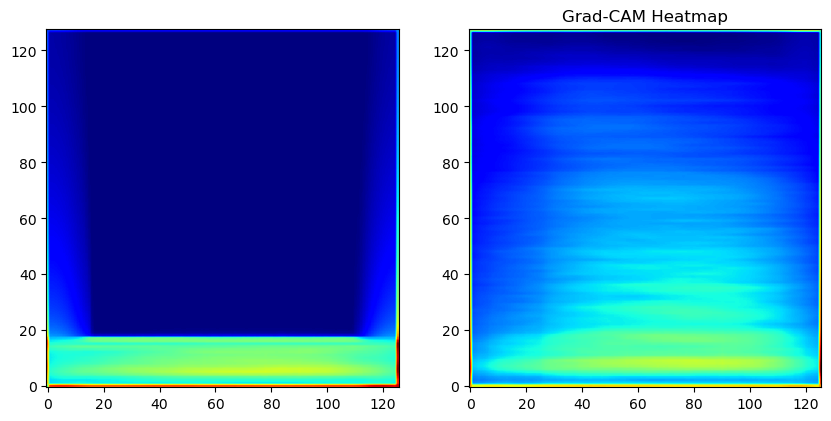

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low80e_total150e


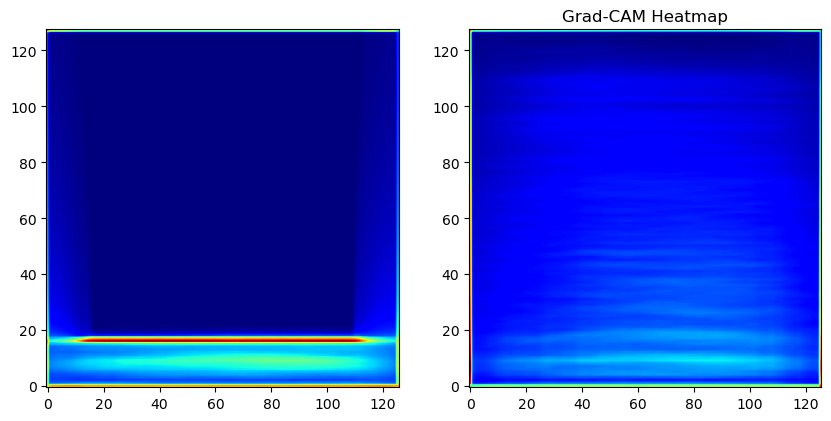

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low10e_total30e


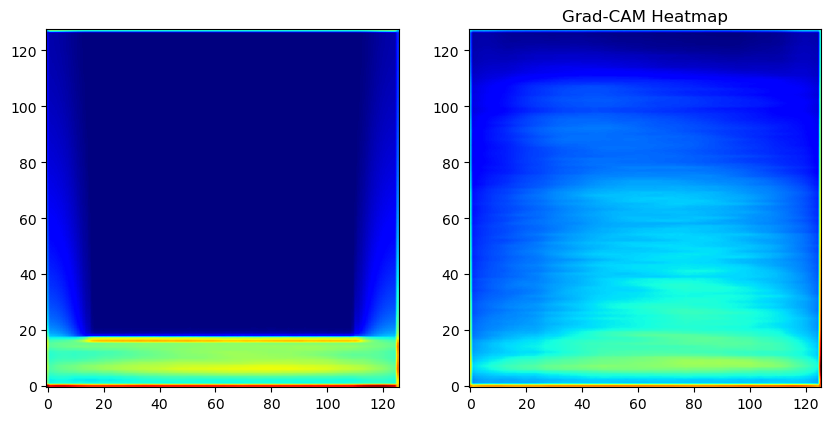

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total170e


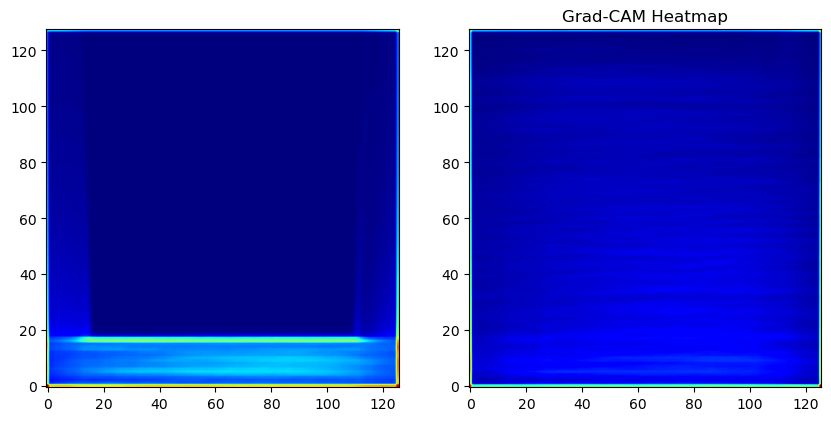

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low70e_total90e


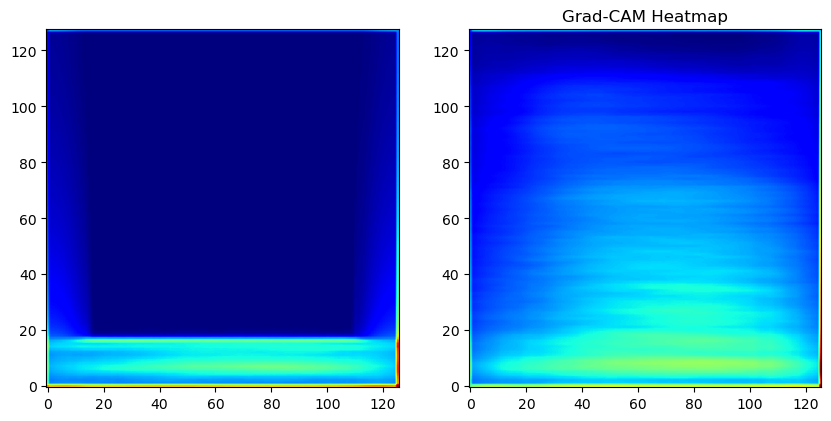

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low60e_total180e


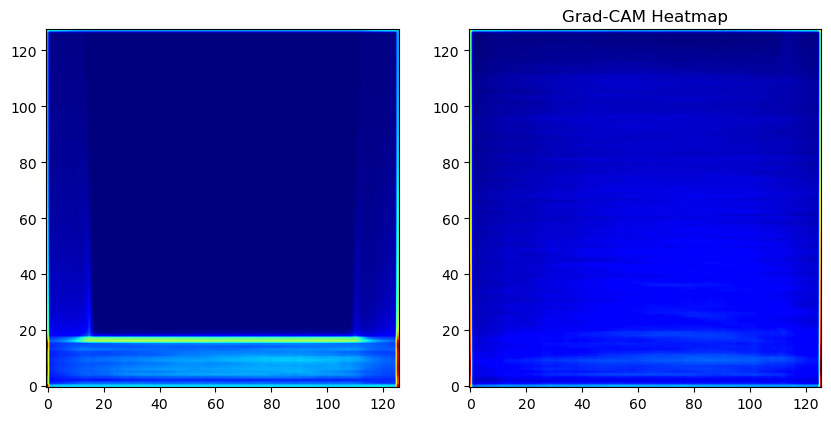

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total50e


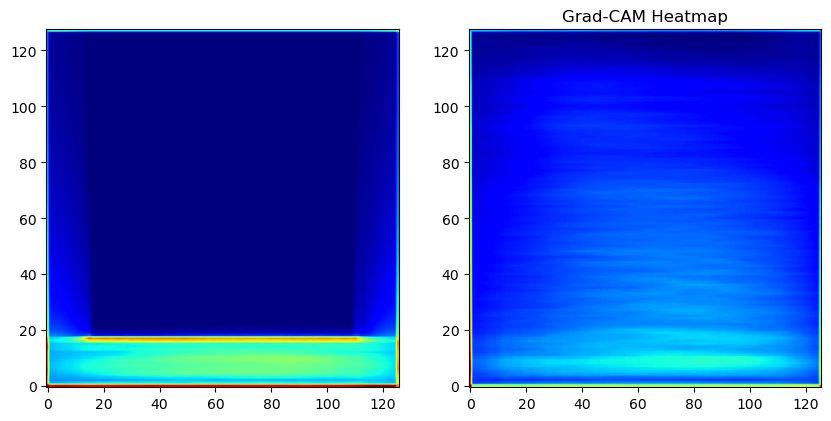

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total110e


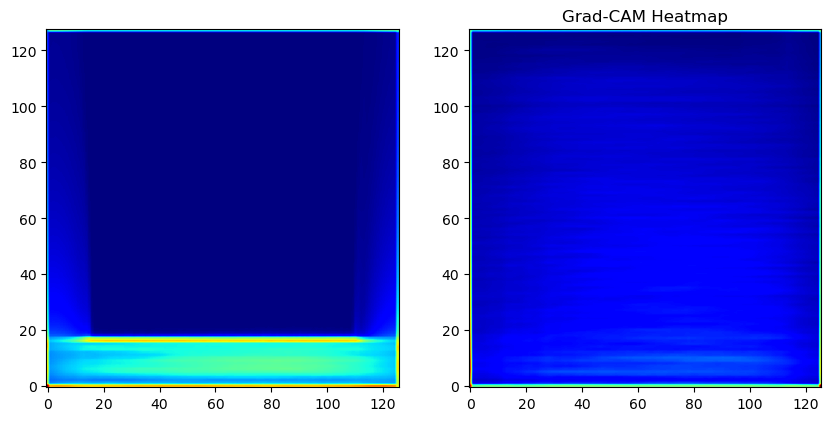

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total130e


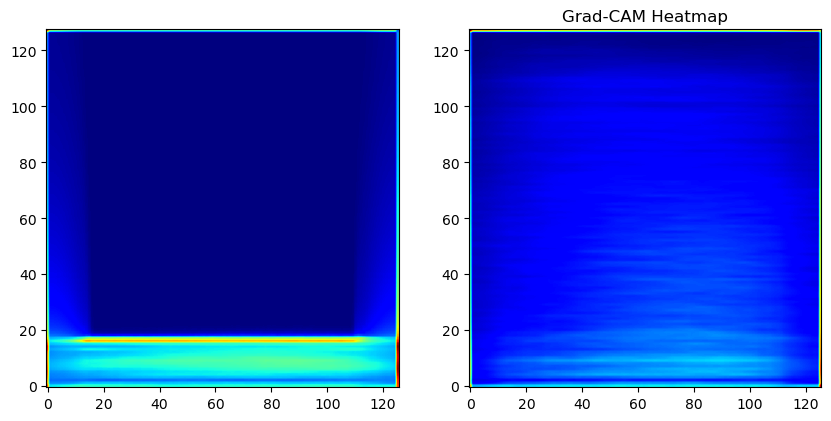

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low40e_total80e


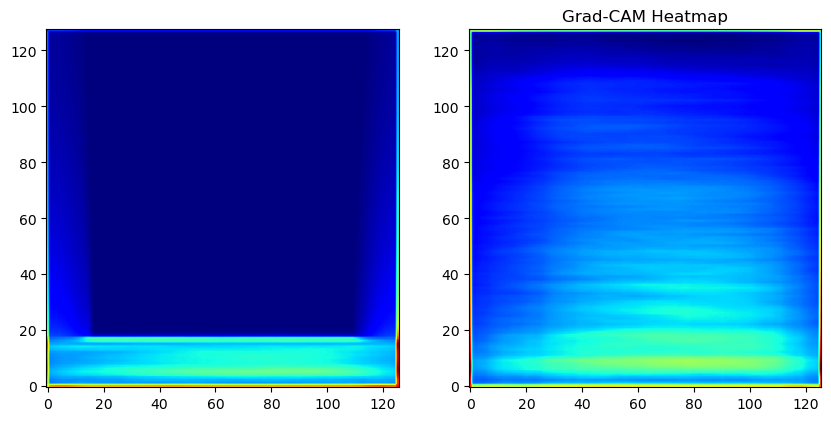

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low80e_total90e


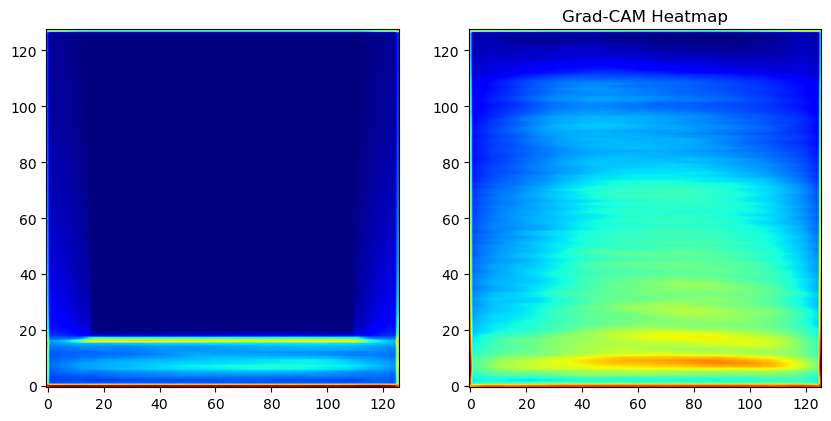

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total190e


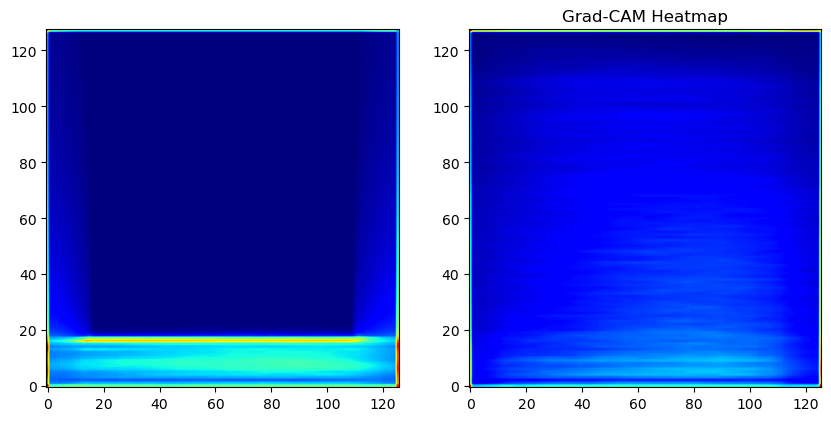

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total70e


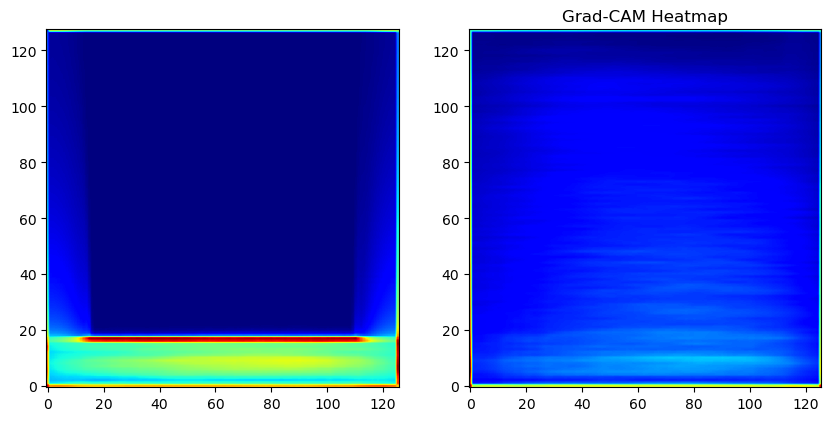

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total120e


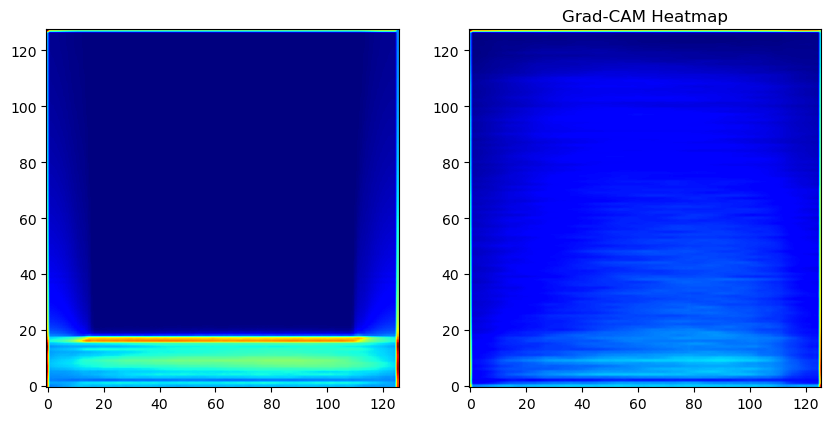

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low20e_total180e


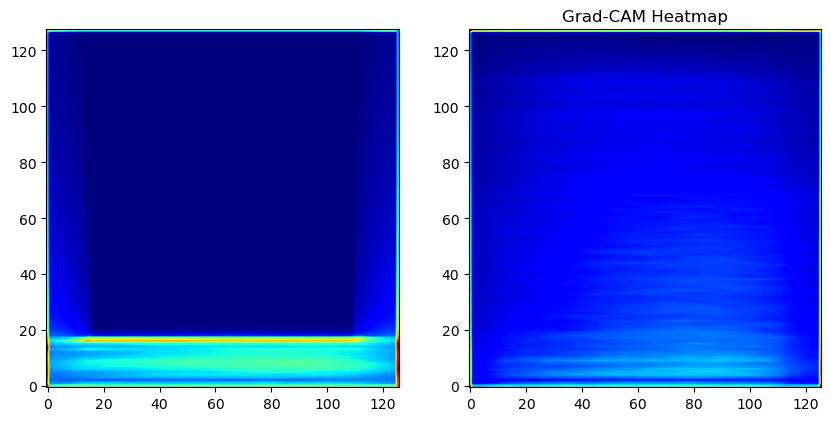

/mnt/storage/compling/proslearn/attention_check/tone/dataset25/tone_dataset25_low30e_total90e


KeyboardInterrupt: 

In [446]:
filenames = glob.glob(os.path.join(f"/mnt/storage/compling/proslearn/attention_check/{checking_domain}/dataset25", f"{checking_domain}_*"))
inputs = pkl.load(open(os.path.join(f"/mnt/storage/compling/proslearn/attention_check/{checking_domain}/dataset25", "input"), "rb"))
for file in filenames:
    print(file)
    data = pkl.load(open(file, "rb"))
    ave_valid_cams = []
    ave_full_cams = []
    for attention_result in data:
        ave_valid_input = torch.sum(torch.stack(inputs['input_valid_tensors']), dim=0)
        ave_full_input = torch.sum(torch.stack(inputs['input_full_tensors']), dim=0)
        ave_valid_cams.append(np.sum(attention_result['cam_valid_tensors'], axis=0))
        ave_full_cams.append(np.sum(attention_result['cam_full_tensors'], axis=0))
    ave_valid_cam = np.sum(ave_valid_cams, axis=0)
    ave_full_cam = np.sum(ave_full_cams, axis=0)
    grad_cam_visualization_both([ave_valid_input,ave_full_input], [ave_valid_cam,ave_full_cam], title=f"Grad-CAM Heatmap",input_alpha=0,output_alpha=1)